{'record_name': 'voice001', 'n_sig': 1, 'fs': 8000, 'counter_freq': None, 'base_counter': None, 'sig_len': 38080, 'base_time': None, 'base_date': None, 'comments': ['<age>: 32  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none'], 'sig_name': ['voice'], 'p_signal': array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [ 0.00354004],
       [-0.03735352],
       [-0.02871704]], shape=(38080, 1)), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['voice001.dat'], 'fmt': ['32'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [4079702243.3775], 'baseline': [-260023747], 'units': ['NU'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-260023747], 'checksum': [14973], 'block_size': [0]}


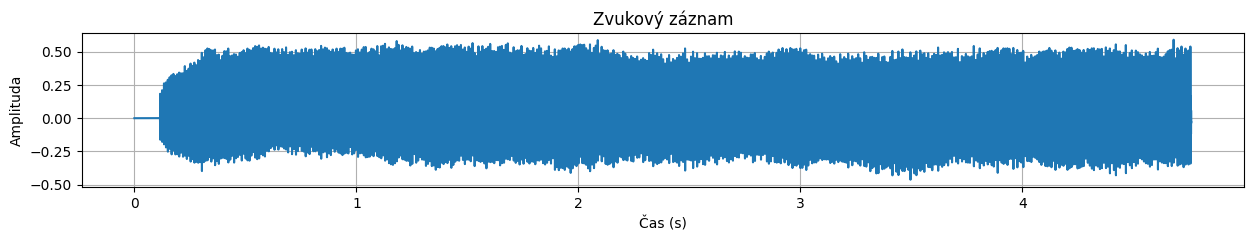

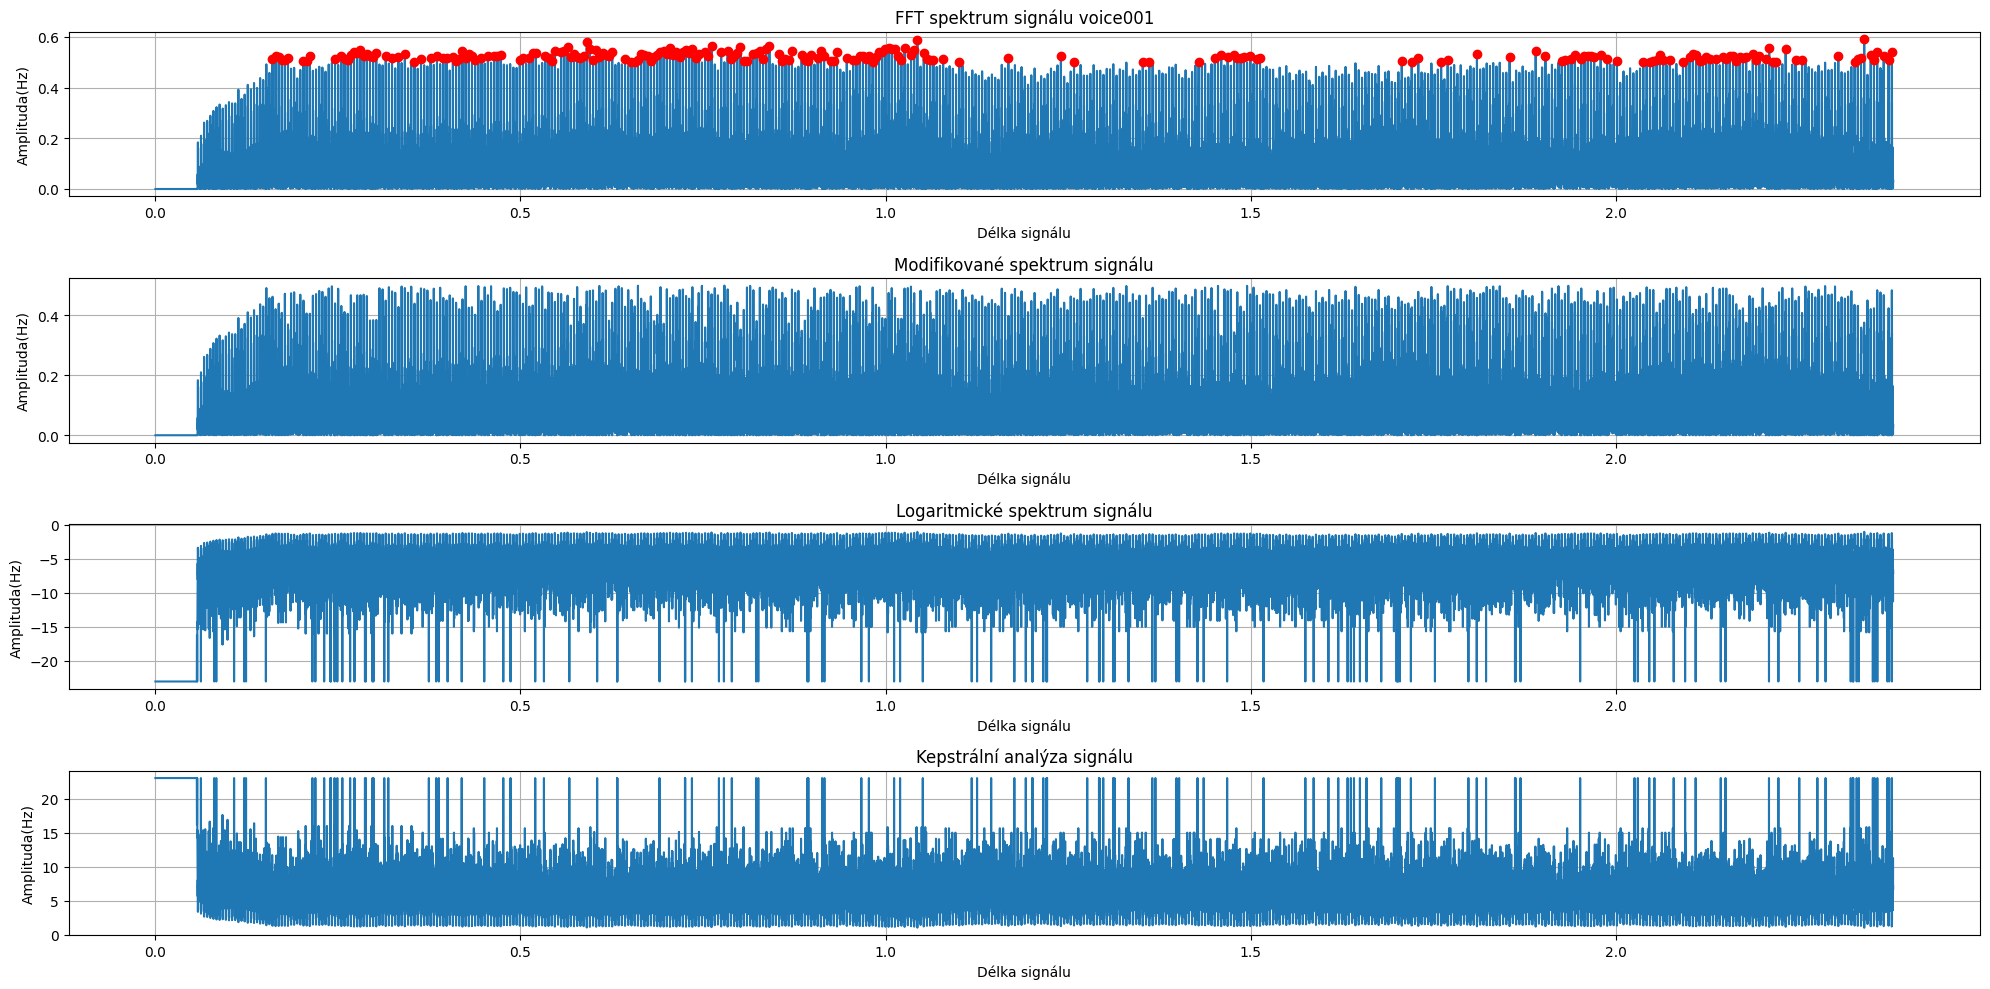

['<age>: 32  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none']
voice001 je patologický


C:\Users\imang\AppData\Local\Temp\ipykernel_21156\3263071721.py:121: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(np.fft.fft(signal),fs=vz_f, nperseg=256)


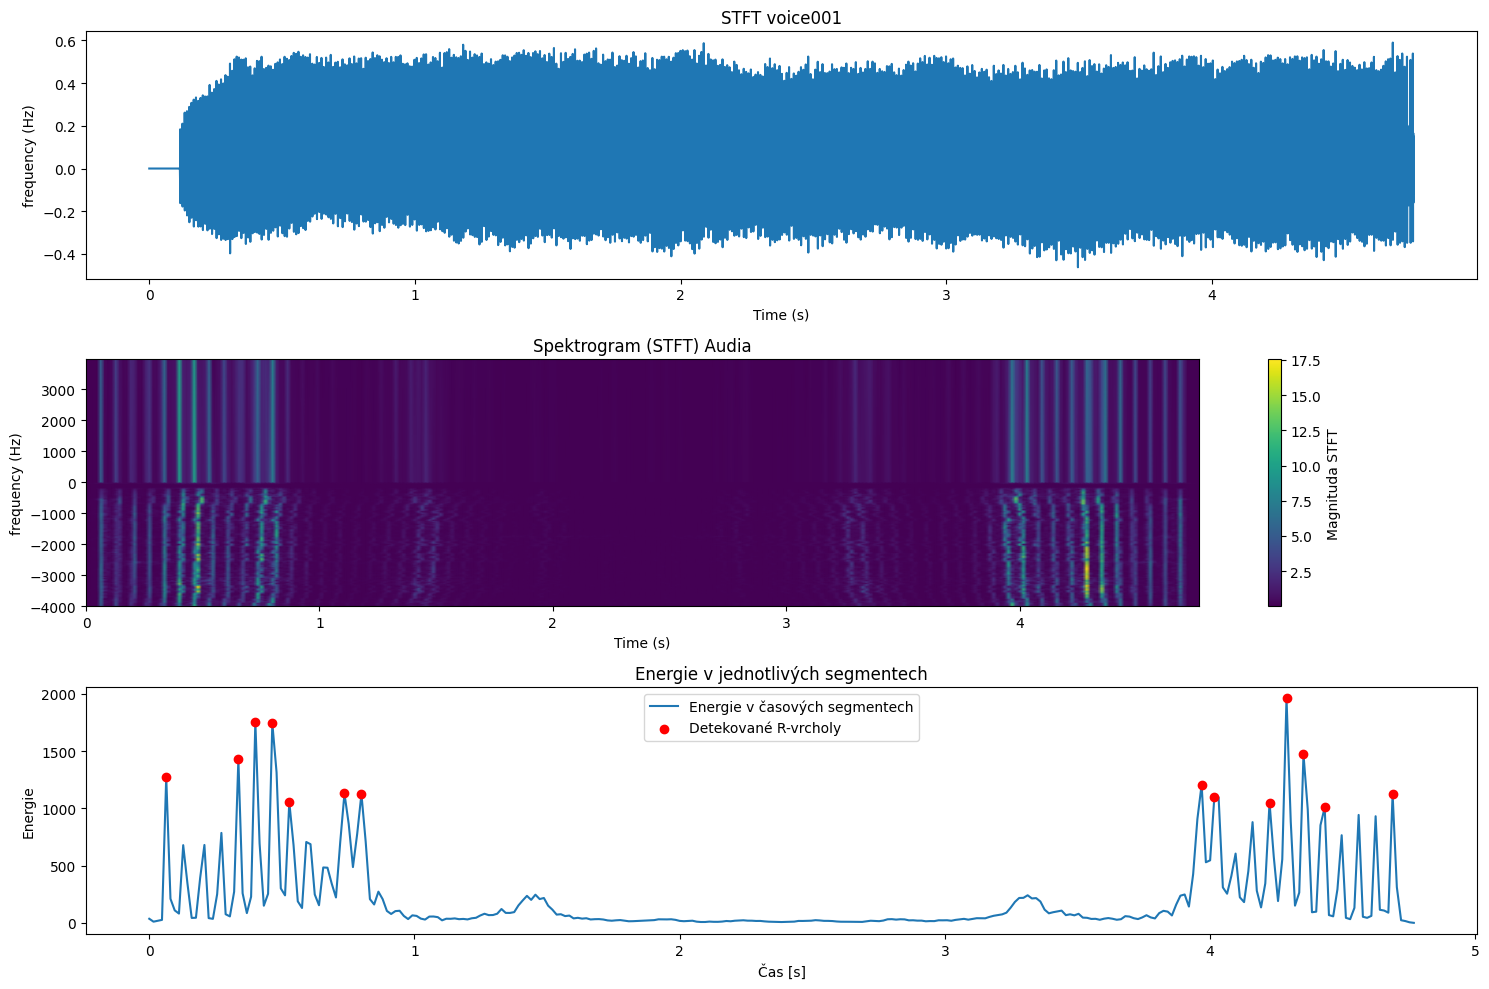

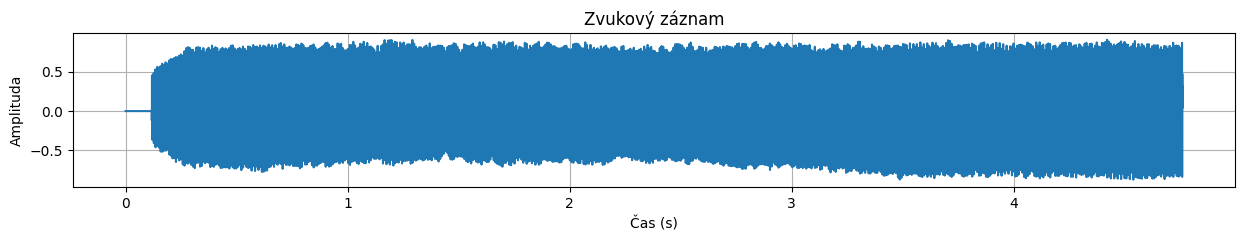

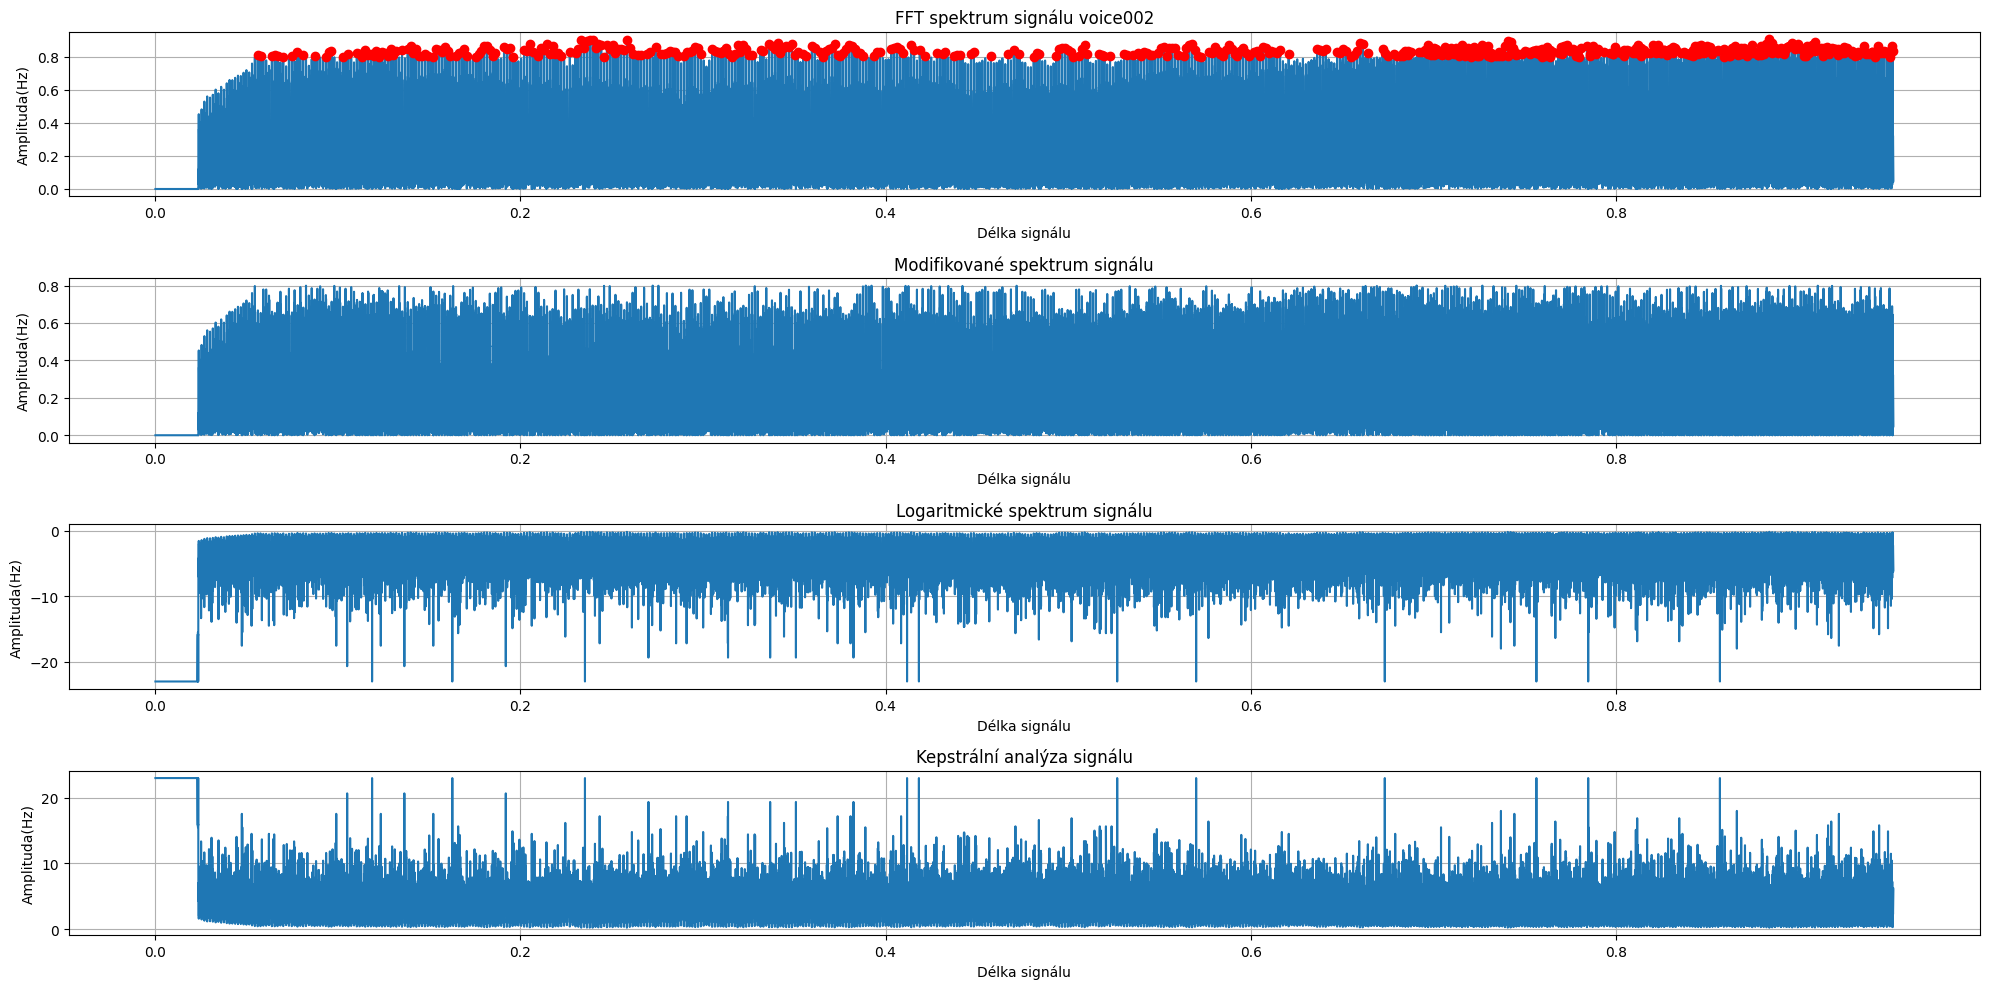

['<age>: 55  <sex>: M <diagnoses>: healthy <medications>: none']
voice002 je patologický


In [249]:
#úkol: klasifikace zvukových signálů na dobré a patologické pomocí různých technik pomocí Fourierovy a kepstrální analýzy,... v případe klasifikujte poruchy + porovnat s technikami které provedli experti
#výstup: grafy demostrující práci se signálem v časové nebo frekvenční oblasti, viualizace a klasifikace v prostoru nebo pomocí parametrů, tabulka s úspěšností klasifikace na jednotlivé skupiny a patologické signály.
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import stft, find_peaks

def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

#nejdřív si vykreslím zvukový signál
def plot_audio(time_axis,signal):
    plt.figure(figsize=(15, 2))
    plt.plot(time_axis, signal)
    plt.title("Zvukový záznam"); plt.xlabel("Čas (s)"); plt.ylabel("Amplituda")
    plt.grid()
    plt.show()
#aby se i audio dalo přehrát
def play_audio(signal, fs):
    import sounddevice as sd
    sd.play((signal*32767).astype(np.int16),samplerate=fs)
    sd.wait()

record = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy\voice001") #načtu si zvukový soubor
print(f"{record.__dict__}") #Načtu si informace o zvukové nahrávce, abych věděl, co obsahuje.
signal = record.p_signal #vezmu si ze souboru signál zvuku
vz_f = record.fs #vzorkovací frekvence zvuku
time = len(signal)/vz_f #výpočet času audia
time_axis = np.linspace(0,time,len(signal)) #vytvořím časovou osu zvuku

plot_audio(time_axis,signal)
play_audio(signal, vz_f) 

def plot_fft_signal(fqs_axis, spectrum, peak_fqs, peaks, fqs2_axis, modified_spectrum, fqs3_axis, log_sp, fqs4_axis, cepstrum, signal_name):
    plt.figure(figsize=(20, 10))
    plt.subplot(4, 1, 1)
    plt.plot(fqs_axis, spectrum)
    plt.plot(peak_fqs,peaks, linestyle='None', marker='o', color='red', label="R-vrcholy")
    plt.title(f"FFT spektrum signálu {signal_name}")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(4, 1, 2)
    plt.plot(fqs2_axis, modified_spectrum)
    plt.title(f"Modifikované spektrum signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(4, 1, 3)
    plt.plot(fqs3_axis, log_sp)
    plt.title("Logaritmické spektrum signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(4, 1, 4)
    plt.plot(fqs4_axis, cepstrum)
    plt.title("Kepstrální analýza signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.tight_layout()
    plt.show()

#fourierova transformace signálu
def fft_transform(signal, fs, down_limit, signal_range=0.2):
    _1D_f_t = np.fft.fft(signal) #fourierova transformace
    fft_spectrum = np.abs(_1D_f_t) #spektrum fourierovy transformace
    fqs_t = np.arange(len(signal))/fs*signal_range #osa frekvencí fourierovy transformace 
    
    #zde si vytvořím spektrum se smazanými vrcholy, které jsou vyšší než dolní hranice
    modified_spectrum = fft_spectrum.copy() #kopie spektra
    modified_spectrum[modified_spectrum>down_limit] = 0 #modifikace spektra
    
    log_sp = np.log(fft_spectrum**2+1e-10) #logaritmická verze spektra
    #inverzní fft
    invers_fft = np.abs(np.fft.ifft(log_sp)) #kepstrální analýza 2

    #zde budu detetokat abnormality u signálu
    peaks, _ = find_peaks(fft_spectrum[:, 0], height=down_limit) #najdem vrcholy, které jsou vyšší než dolní limit
    peak_fqs = fqs_t[peaks] #frekvence, kde jsou vrcholy
    peak_magnitudes = fft_spectrum[peaks] #magnitudy vrcholů

    #například když vrcholů bude víc než 3, tak signál bude patologický
    is_pathological = len(peak_fqs) > 3 or np.max(fft_spectrum) > 0.8 #bool kde rozliším jestli je patologický nebo ne

    return fqs_t, fft_spectrum, modified_spectrum, log_sp, invers_fft, peak_magnitudes, peak_fqs, is_pathological #vrátím data abych si mohl signál vykreslit



down_limit = 0.8 #nastavím si dolní hranici pro signál hranice 0.5 Hz

#zde jsem useknul přes fourierovu transformaci frekvence vyšší než 0.5 Hz
fqs, spectrum, modified_spectrum, log_spectrum, ifft_spectrum, peaks, peak_fqs, is_pathological = fft_transform(signal,vz_f,down_limit, signal_range=0.5)

#vykreslím si grafy signálů
plot_fft_signal(fqs,spectrum,peak_fqs,peaks,fqs,modified_spectrum,fqs,log_spectrum, fqs, ifft_spectrum, signal_name=record.record_name)

#vypíšu jestli je signál patologický
print(f"{record.__dict__['comments']}") #načtu si z informací jestli tento člověk má nějakou diagnozu
if is_pathological: print(f"{record.record_name} je patologický")
else: print(f"{record.record_name} není patologický")

#inverzní fft2, pomocí funkce z knihovny scipy 2. způsob
def inverse_fft2(signal, fs):
    spectrum = np.abs(fft(signal)) #udělám fourierovu transformaci
    fft_axis = np.arange(len(signal))/fs
    log_sp = np.log(spectrum)#+np.finfo(float).eps) #zlogaritmování + přidání eps pro přesnost
    invers_fft = np.abs(ifft(log_sp)) #kepstrální analýza
    ifft_time_axis = np.arange(len(invers_fft))/fs #vytvoření časové osy pro kepstrální analýzu
    return fft_axis, spectrum, log_sp, ifft_time_axis, invers_fft

#fft_time, spectrum, log_sp, ifft_time_axis, invers_fft = inverse_fft2(signal,vz_f)
#plot_fft_signal(fft_time,spectrum,peak_fqs,peaks, fft_time, spectrum, fft_time, log_sp, fft_time, invers_fft, signal_name=record.record_name)
#play_audio(inverse_fft_,vz_f)

#short time fouriers transform

#aby jsme mohli s daty pracovat pole musí být 1d
if signal.ndim > 1: signal = signal.mean(axis=1) 

f, t, Zxx = stft(np.fft.fft(signal),fs=vz_f, nperseg=256)
energy=np.sum(np.abs(Zxx),axis=0)
peaks, _ = find_peaks(energy,height=np.max(energy)*0.5)

def plot_stft(time_axis, signal, f, t, Zxx, peaks, signal_name):
    plt.figure(figsize=(15, 10))
    plt.subplot(3,1,1)
    plt.plot(time_axis,signal)
    plt.title(f"STFT {signal_name}")
    plt.ylabel("frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.subplot(3, 1, 2)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.colorbar(label='Magnituda STFT')
    plt.ylabel("frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title('Spektrogram (STFT) Audia')
    plt.subplot(3, 1, 3)
    plt.plot(t, energy, label='Energie v časových segmentech')
    plt.scatter(t[peaks], energy[peaks], color='red', label='Detekované R-vrcholy', zorder=5)
    plt.xlabel('Čas [s]')
    plt.ylabel('Energie')
    plt.title('Energie v jednotlivých segmentech')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_stft(time_axis, signal, f, t, Zxx, peaks, signal_name=record.record_name)

#vyzkouším další audio
record = Nacti_soubor(r"C:\Users\imang\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy\voice002")
signal = record.p_signal 
vz_f = record.fs 
time = len(signal)/vz_f 
time_axis = np.linspace(0,time,len(signal)) 

plot_audio(time_axis,signal)
play_audio(signal, vz_f) 

down_limit=0.8
fqs, spectrum, modified_spectrum, log_spectrum, ifft_spectrum, peaks, peak_fqs, is_pathological = fft_transform(signal,vz_f,down_limit)

#vykreslím si grafy signálů
plot_fft_signal(fqs,spectrum,peak_fqs,peaks,fqs,modified_spectrum,fqs,log_spectrum, fqs, ifft_spectrum, signal_name=record.record_name)

#vypíšu jestli je signál patologický

print(f"{record.__dict__['comments']}")
if is_pathological: print(f"{record.record_name} je patologický")
else: print(f"{record.record_name} není patologický")